In [1]:
import torch
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
%matplotlib inline


In [2]:
words=open("names.txt",'r').read().splitlines()
chars=sorted(list(set(''.join(words))))
stoi={s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}
vocab_size=len(itos)
vocab_size

27

In [3]:
import random   
random.seed(42) 
random.shuffle(words)

In [210]:
block_size=8 

def build_dataset(words):
    x,y=[],[]

    for w in words:
        context=[0]*block_size 
        for ch in w + '.':
            ix=stoi[ch]
            x.append(context)
            y.append(ix)
            context=context[1:]+[ix]
    x=torch.tensor(x)
    y=torch.tensor(y)
    print(x.shape,y.shape)
    return (x,y)

n1=int(len(words)*0.8)
n2=int(len(words)*0.9)
xtr,ytr=build_dataset(words[:n1])
xdev,ydev=build_dataset(words[n1:n2])
xtest,ytest=build_dataset(words[n2:])


torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [211]:
for x,y in zip(xtr[:20],ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x),"-->",itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [212]:
class Linear:
    def __init__(self,fan_in,fan_out,bias=True):
        self.weight=torch.randn((fan_in,fan_out),generator=g)/fan_in**0.5
        self.bias=torch.randn((fan_out)) if bias else None
    def __call__(self,x):
        self.out=x@self.weight
        if self.bias is not None:
            self.out+=self.bias 
        return self.out 
    def parameters(self):
        return [self.weight]+([] if self.bias is None else [self.bias])

class BatchNorm1d:
    
    def __init__(self,dim,eps=1e-5,momentum=0.1):
        self.eps=eps 
        self.momentum=momentum 
        self.training=True 

        self.gamma=torch.ones(dim)
        self.beta=torch.zeros(dim) 

        self.running_mean=torch.zeros(dim)
        self.running_var=torch.ones(dim)

    def __call__(self,x):
        if self.training:
            xmean=x.mean(0,keepdim=True)
            xvar=x.var(0,keepdim=True)
        else:
            xmean=self.running_mean 
            xvar=self.running_var 
        xhat=(x-xmean)/torch.sqrt(xvar+self.eps)
        self.out=self.gamma*xhat+self.beta 
        if self.training:
            with torch.no_grad():
                self.running_mean=(1-self.momentum)*self.running_mean+self.momentum*xmean
                self.running_var=(1-self.momentum)*self.running_var+self.momentum*xvar 
        return self.out 
    
    def parameters(self):
        return [self.gamma,self.beta]
    
class Tanh:
    def __call__(self,x):
        self.out=torch.tanh(x)
        return self.out 
    def parameters(self):
        return []

class Embedding:
    def __init__(self,num_embeddings,embedding_dim):
        self.weight=torch.randn((num_embeddings,embedding_dim)) 
    def __call__(self,IX):
        self.out=self.weight[IX]
        return self.out 
    def parameters(self):
        return [self.weight]

class Flatten:
    def __call__(self,x):
        self.out=x.view(x.shape[0],-1)
        return self.out
    def parameters(self):
        return []

class Sequential:
    def __init__(self,layers):
        self.layers=layers
    def __call__(self,x):
        for layer in self.layers:
            x=layer(x)
        self.out=x 
        return self.out
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]        




In [213]:
n_embd=10 
n_hidden=100 
g=torch.Generator().manual_seed(2147483647)
C=torch.randn((vocab_size,n_embd), generator=g)

model=Sequential([Embedding(vocab_size,n_embd),
        Flatten(),
    Linear(n_embd*block_size,n_hidden,bias=False), BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden,n_hidden,bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden,vocab_size,bias=False), BatchNorm1d(vocab_size),
])

with torch.no_grad():
    layers[-1].gamma*=0.1 

    for layer in layers[:-1]:
        if isinstance(layer,Linear):
            layer.weight*=1.0

parameters=model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad=True 


    

21424


In [214]:
max_steps=200000
batch_size=32
lossi=[]
ud=[]

for i in range(max_steps):
    ix=torch.randint(0,xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb=xtr[ix],ytr[ix]
    
    #forward pass 
    logits=model(Xb)      
    loss=F.cross_entropy(logits,Yb)
    
    # backward pass 
    for p in parameters:
        p.grad=None 
    loss.backward()
    
    # update 
    lr=0.1 if i <150000 else 0.01 
    for p in parameters:
        p.data+=-lr * p.grad 

    if i %10000 ==0: 
        print(f'{i:7d}/{max_steps:7d}: {loss.item(): .4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std()/p.data.std()).log10().item() for p in parameters])
    
    # if i >=1000:
    #     break

      0/ 200000:  3.6500
  10000/ 200000:  2.0514
  20000/ 200000:  1.8646
  30000/ 200000:  2.3996
  40000/ 200000:  2.2818
  50000/ 200000:  1.6921
  60000/ 200000:  2.3223
  70000/ 200000:  1.8598
  80000/ 200000:  2.0164
  90000/ 200000:  2.3533
 100000/ 200000:  1.8452
 110000/ 200000:  2.4336
 120000/ 200000:  2.1515
 130000/ 200000:  1.8058
 140000/ 200000:  2.0410
 150000/ 200000:  2.0499
 160000/ 200000:  1.8694
 170000/ 200000:  1.7901
 180000/ 200000:  2.0111
 190000/ 200000:  1.7445


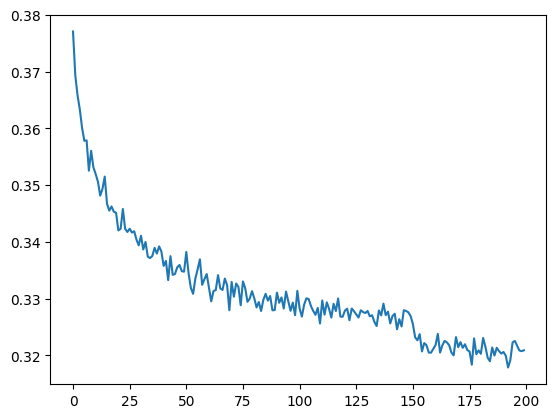

In [202]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [203]:
for layer in model.layers:
    layer.training=False

In [204]:
@torch.no_grad() 
def split_loss(split):
    x,y={
        'train':(xtr,ytr),
        'val':(xdev,ydev),
        'test':(xtest,ytest),
    }[split]
    
    
    logits=model(x)
    loss=F.cross_entropy(logits,y)
    print(split,loss.item())


split_loss('train')
split_loss('val')
    

train 2.0482821464538574
val 2.0981359481811523


In [209]:
g = torch.Generator().manual_seed(2147483647 + 4)
for _ in range(20):
    out=[]
    context=[0]*block_size 
    while True:
        x=[torch.tensor([context])]
        logits=model(x)
        probs=F.softmax(logits,dim=1)
        ix=torch.multinomial(probs,num_samples=1,generator=g).item()
        context=context[1:]+[ix] 
        out.append(ix)
        if ix==0:
            break 
    print(''.join(itos[i] for i in out))


jhyla.
owaied.
jascen.
kiyah.
kjleon.
laj.
jadyn.
blan.
sav.
cam.
breanna.
yialus.
walzion.
fetz.
sai.
lnia.
bryn.
tiyannesira.
lyyson.
kee.


In [183]:
e=torch.randn(4,8,2)


In [197]:
torch.cat([e[:,::2,:],e[:,1::2,:]],dim=2)

tensor([[[-1.1888,  1.1853,  0.1336,  1.4479],
         [-0.7281,  0.5876, -0.3590,  1.4208],
         [ 0.3031,  0.7373,  1.0249, -1.5797],
         [-0.8609,  0.9390,  1.6297,  0.1165]],

        [[-0.6505, -1.0839, -1.9801, -0.0572],
         [-0.1947,  0.2779,  0.5693,  1.7241],
         [ 0.0486, -0.1466,  0.4597,  0.5189],
         [ 0.8434, -0.2672,  1.5838,  0.3616]],

        [[ 0.7754, -0.2861,  0.7337,  0.3109],
         [-0.4622, -0.0828,  1.2457, -0.2236],
         [-0.3389, -0.8510,  0.2117,  2.0274],
         [-0.6371, -0.9957, -0.2822,  0.3226]],

        [[-0.1193, -0.8845, -0.4852,  0.2287],
         [-1.7908,  1.0058, -1.5909,  0.7137],
         [-0.3841,  1.3215,  0.6612,  0.6095],
         [ 0.3864,  2.8574, -0.5519, -0.9656]]])

In [201]:
e

tensor([[[-1.1888,  1.1853],
         [ 0.1336,  1.4479],
         [-0.7281,  0.5876],
         [-0.3590,  1.4208],
         [ 0.3031,  0.7373],
         [ 1.0249, -1.5797],
         [-0.8609,  0.9390],
         [ 1.6297,  0.1165]],

        [[-0.6505, -1.0839],
         [-1.9801, -0.0572],
         [-0.1947,  0.2779],
         [ 0.5693,  1.7241],
         [ 0.0486, -0.1466],
         [ 0.4597,  0.5189],
         [ 0.8434, -0.2672],
         [ 1.5838,  0.3616]],

        [[ 0.7754, -0.2861],
         [ 0.7337,  0.3109],
         [-0.4622, -0.0828],
         [ 1.2457, -0.2236],
         [-0.3389, -0.8510],
         [ 0.2117,  2.0274],
         [-0.6371, -0.9957],
         [-0.2822,  0.3226]],

        [[-0.1193, -0.8845],
         [-0.4852,  0.2287],
         [-1.7908,  1.0058],
         [-1.5909,  0.7137],
         [-0.3841,  1.3215],
         [ 0.6612,  0.6095],
         [ 0.3864,  2.8574],
         [-0.5519, -0.9656]]])